In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import os
import torchvision.models as tmodels
from termcolor import colored
%matplotlib inline
torch.__version__

'1.7.1'

In [2]:
#data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

BATCH_SIZE=32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_subset, val_subset = torch.utils.data.random_split(trainset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
from model import Net
net = Net(BATCH_SIZE)

print(net)

def train(epochs):
    min_acc = -np.inf
    epoch_losses = []
    epoch_accs = []
    for epoch in range(epochs):  # loop over the dataset multiple times

        epoch_loss = 0.0
        epoch_acc = 0.
        val_acc = -np.inf
        val_loss = np.inf
        pbar = tqdm(enumerate(trainloader, 0))
        for i, data in pbar:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(net.device), data[1].to(net.device)

            # zero the parameter gradients
            net.optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = net.loss_fn(outputs, labels)
            loss.backward()
            net.optimizer.step()

            pred = torch.argmax(outputs, axis=1)
            running_acc = (pred == labels).float().sum() / BATCH_SIZE * 100
            running_loss = loss.item()

            epoch_acc += running_acc
            epoch_loss += running_loss

            # print statistics
            pbar.set_description(f'Epoch: {epoch}, Done {(i + 1)/len(trainloader) * 100}%, Loss: {running_loss}, Accuracy: {running_acc}%')
            pbar.update(BATCH_SIZE)
        pbar.close()

        val_acc, val_loss = test(valloader)

        net.scheduler.step(val_loss)
        
        epoch_loss /= len(trainloader)
        epoch_acc /= len(trainloader)
        
        epoch_losses.append(epoch_loss)
        epoch_accs.append(epoch_acc)

        print(f"Avg loss: {colored(str(epoch_loss), 'green')}, Avg accuracy: {colored(str(epoch_acc.item()), 'red')}, Val loss: {val_loss}, Val accuracy: {val_acc}")

        if val_acc > min_acc:
            print(f'Improved val acc from {min_acc} to {val_acc}, saving model')
            min_acc = val_acc
            net.save()
        else:
            print(f'Val acc did not improve from {min_acc}')

    print('Finished Training')
    return epoch_accs, epoch_losses

def test(dataloader):
    correct = 0.
    total = 0.
    loss = 0.
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(net.device), data[1].to(net.device)
            outputs = net(images)
            loss += net.loss_fn(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total * 100, loss / total
    

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (act): Softmax(dim=-1)
)


In [4]:
accs, losses = train(60)
acc, loss = test(testloader)
print(f'Test acc: {acc}%, test loss: {loss}')

Epoch: 0, Done 100.0%, Loss: 1.1926008462905884, Accuracy: 56.25%: : 1250it [00:09, 132.09it/s]                


Avg loss: 1.473853985786438, Avg accuracy: 46.64500045776367, Val loss: 0.04139217493534088, Val accuracy: 52.75
Improved val acc from -inf to 52.75, saving model


Epoch: 1, Done 100.0%, Loss: 1.154412031173706, Accuracy: 62.5%: : 1250it [00:09, 132.41it/s]                  


Avg loss: 1.2197619728565217, Avg accuracy: 56.38999938964844, Val loss: 0.03823292698860169, Val accuracy: 57.34
Improved val acc from 52.75 to 57.34, saving model


Epoch: 2, Done 100.0%, Loss: 1.176527500152588, Accuracy: 62.5%: : 1250it [00:09, 135.73it/s]                  


Avg loss: 1.1185725759506226, Avg accuracy: 60.20499801635742, Val loss: 0.0350285901427269, Val accuracy: 60.8
Improved val acc from 57.34 to 60.8, saving model


Epoch: 3, Done 100.0%, Loss: 1.2666642665863037, Accuracy: 62.5%: : 1250it [00:09, 132.11it/s]                 


Avg loss: 1.0511551582813263, Avg accuracy: 62.75749969482422, Val loss: 0.033914921659231184, Val accuracy: 61.46
Improved val acc from 60.8 to 61.46, saving model


Epoch: 4, Done 100.0%, Loss: 0.8859657049179077, Accuracy: 65.625%: : 1250it [00:09, 132.43it/s]               


Avg loss: 0.9967156314134598, Avg accuracy: 64.80249786376953, Val loss: 0.033760360145568845, Val accuracy: 62.29
Improved val acc from 61.46 to 62.29, saving model


Epoch: 5, Done 100.0%, Loss: 0.8733826279640198, Accuracy: 62.5%: : 1250it [00:09, 130.14it/s]                 


Avg loss: 0.951310887336731, Avg accuracy: 66.58999633789062, Val loss: 0.033429078659415246, Val accuracy: 63.27
Improved val acc from 62.29 to 63.27, saving model


Epoch: 6, Done 100.0%, Loss: 0.9510334134101868, Accuracy: 68.75%: : 1250it [00:09, 137.40it/s]                


Avg loss: 0.914884925198555, Avg accuracy: 67.81499481201172, Val loss: 0.03185213212966919, Val accuracy: 64.46
Improved val acc from 63.27 to 64.46, saving model


Epoch: 7, Done 100.0%, Loss: 0.715619683265686, Accuracy: 71.875%: : 1250it [00:09, 134.65it/s]                 


Avg loss: 0.8795078122377396, Avg accuracy: 68.77999877929688, Val loss: 0.03186752808094025, Val accuracy: 64.56
Improved val acc from 64.46 to 64.56, saving model


Epoch: 8, Done 100.0%, Loss: 0.6898714303970337, Accuracy: 68.75%: : 1250it [00:09, 135.92it/s]                 


Avg loss: 0.8535380349397659, Avg accuracy: 69.88999938964844, Val loss: 0.031840933895111084, Val accuracy: 65.12
Improved val acc from 64.56 to 65.12, saving model


Epoch: 9, Done 100.0%, Loss: 0.8620725870132446, Accuracy: 71.875%: : 1250it [00:09, 132.63it/s]               


Avg loss: 0.8246450659751892, Avg accuracy: 71.0, Val loss: 0.032420337790250775, Val accuracy: 64.38000000000001
Val acc did not improve from 65.12


Epoch: 10, Done 100.0%, Loss: 1.1590520143508911, Accuracy: 62.5%: : 1250it [00:09, 129.17it/s]                 


Avg loss: 0.8050168173789978, Avg accuracy: 71.8125, Val loss: 0.03216720452606678, Val accuracy: 64.38000000000001
Val acc did not improve from 65.12


Epoch: 11, Done 100.0%, Loss: 0.8076329231262207, Accuracy: 78.125%: : 1250it [00:09, 127.27it/s]               


Avg loss: 0.7847910149812698, Avg accuracy: 72.28499603271484, Val loss: 0.03151771841645241, Val accuracy: 65.34
Improved val acc from 65.12 to 65.34, saving model


Epoch: 12, Done 100.0%, Loss: 1.155470371246338, Accuracy: 59.375%: : 1250it [00:09, 132.04it/s]                 


Avg loss: 0.7616339210748673, Avg accuracy: 73.06749725341797, Val loss: 0.032139586919546125, Val accuracy: 64.86
Val acc did not improve from 65.34


Epoch: 13, Done 100.0%, Loss: 0.5671999454498291, Accuracy: 81.25%: : 1250it [00:09, 133.18it/s]                 


Avg loss: 0.7481698528051376, Avg accuracy: 73.7249984741211, Val loss: 0.03148675557672977, Val accuracy: 65.2
Val acc did not improve from 65.34


Epoch: 14, Done 100.0%, Loss: 0.6666924357414246, Accuracy: 84.375%: : 1250it [00:09, 131.61it/s]               


Avg loss: 0.7290759099245071, Avg accuracy: 74.33999633789062, Val loss: 0.03184468516409397, Val accuracy: 65.32
Val acc did not improve from 65.34


Epoch: 15, Done 100.0%, Loss: 0.5151363611221313, Accuracy: 84.375%: : 1250it [00:09, 133.43it/s]               


Avg loss: 0.7156553141593933, Avg accuracy: 74.90249633789062, Val loss: 0.03242746599912644, Val accuracy: 65.53999999999999
Improved val acc from 65.34 to 65.53999999999999, saving model


Epoch: 16, Done 100.0%, Loss: 0.8280926942825317, Accuracy: 75.0%: : 1250it [00:08, 141.59it/s]                  


Avg loss: 0.7043902327895164, Avg accuracy: 75.1199951171875, Val loss: 0.03281599678993225, Val accuracy: 64.91
Val acc did not improve from 65.53999999999999


Epoch: 17, Done 100.0%, Loss: 0.7947034239768982, Accuracy: 65.625%: : 1250it [00:09, 130.83it/s]                


Avg loss: 0.6908296799421311, Avg accuracy: 75.44999694824219, Val loss: 0.033176857960224154, Val accuracy: 64.71000000000001
Val acc did not improve from 65.53999999999999


Epoch: 18, Done 100.0%, Loss: 0.7239672541618347, Accuracy: 65.625%: : 1250it [00:09, 131.89it/s]                


Avg loss: 0.6757757076025009, Avg accuracy: 76.20249938964844, Val loss: 0.03215190882086754, Val accuracy: 65.86999999999999
Improved val acc from 65.53999999999999 to 65.86999999999999, saving model


Epoch: 19, Done 100.0%, Loss: 0.6609452962875366, Accuracy: 75.0%: : 1250it [00:09, 134.94it/s]                  


Avg loss: 0.6678009138464928, Avg accuracy: 76.51249694824219, Val loss: 0.033858462378382685, Val accuracy: 64.94
Val acc did not improve from 65.86999999999999


Epoch: 20, Done 100.0%, Loss: 1.0677266120910645, Accuracy: 59.375%: : 1250it [00:08, 147.66it/s]                


Avg loss: 0.6568628183126449, Avg accuracy: 76.92749786376953, Val loss: 0.03378791528344154, Val accuracy: 65.14
Val acc did not improve from 65.86999999999999


Epoch: 21, Done 100.0%, Loss: 0.8151556253433228, Accuracy: 71.875%: : 1250it [00:09, 135.98it/s]                


Avg loss: 0.6437054002404213, Avg accuracy: 77.36750030517578, Val loss: 0.03371505384147167, Val accuracy: 64.95
Val acc did not improve from 65.86999999999999


Epoch: 22, Done 100.0%, Loss: 0.7275519371032715, Accuracy: 75.0%: : 1250it [00:09, 135.07it/s]                  


Avg loss: 0.6352451801538468, Avg accuracy: 77.43999481201172, Val loss: 0.035258229303359985, Val accuracy: 63.82
Val acc did not improve from 65.86999999999999


Epoch: 23, Done 100.0%, Loss: 0.9828417897224426, Accuracy: 68.75%: : 1250it [00:09, 131.00it/s]                 


Avg loss: 0.6293697764635086, Avg accuracy: 77.80999755859375, Val loss: 0.034654273462295535, Val accuracy: 64.05
Val acc did not improve from 65.86999999999999


Epoch: 24, Done 100.0%, Loss: 0.5521488785743713, Accuracy: 75.0%: : 1250it [00:09, 138.02it/s]                  


Avg loss: 0.6162097872257233, Avg accuracy: 78.23500061035156, Val loss: 0.03410680747330189, Val accuracy: 65.14999999999999
Val acc did not improve from 65.86999999999999


Epoch: 25, Done 100.0%, Loss: 0.4096943438053131, Accuracy: 81.25%: : 1250it [00:09, 132.01it/s]                 


Avg loss: 0.49050106208324434, Avg accuracy: 83.3375015258789, Val loss: 0.03259001868069172, Val accuracy: 66.71000000000001
Improved val acc from 65.86999999999999 to 66.71000000000001, saving model


Epoch: 26, Done 100.0%, Loss: 0.47111964225769043, Accuracy: 87.5%: : 1250it [00:08, 139.49it/s]                 


Avg loss: 0.46612102301120756, Avg accuracy: 84.41999816894531, Val loss: 0.0331144211769104, Val accuracy: 66.47
Val acc did not improve from 66.71000000000001


Epoch: 27, Done 100.0%, Loss: 0.5230350494384766, Accuracy: 78.125%: : 1250it [00:09, 131.79it/s]                


Avg loss: 0.45868227468729017, Avg accuracy: 84.68000030517578, Val loss: 0.033194420900940894, Val accuracy: 66.36
Val acc did not improve from 66.71000000000001


Epoch: 28, Done 100.0%, Loss: 0.38860398530960083, Accuracy: 87.5%: : 1250it [00:09, 134.50it/s]                 


Avg loss: 0.4506673856496811, Avg accuracy: 85.05249786376953, Val loss: 0.03349539370536804, Val accuracy: 66.47
Val acc did not improve from 66.71000000000001


Epoch: 29, Done 100.0%, Loss: 0.7619739174842834, Accuracy: 81.25%: : 1250it [00:09, 133.53it/s]                 


Avg loss: 0.4464780005335808, Avg accuracy: 85.23749542236328, Val loss: 0.03352343859374523, Val accuracy: 66.29
Val acc did not improve from 66.71000000000001


Epoch: 30, Done 100.0%, Loss: 0.4020136892795563, Accuracy: 84.375%: : 1250it [00:09, 130.01it/s]                


Avg loss: 0.43910508958101274, Avg accuracy: 85.41999816894531, Val loss: 0.033826033720374106, Val accuracy: 66.49000000000001
Val acc did not improve from 66.71000000000001


Epoch: 31, Done 100.0%, Loss: 0.28557801246643066, Accuracy: 90.625%: : 1250it [00:09, 138.83it/s]               


Avg loss: 0.4380990117192268, Avg accuracy: 85.36000061035156, Val loss: 0.034293546444177626, Val accuracy: 65.75999999999999
Val acc did not improve from 66.71000000000001


Epoch: 32, Done 100.0%, Loss: 0.4936729073524475, Accuracy: 90.625%: : 1250it [00:09, 135.46it/s]                


Avg loss: 0.43103933045864107, Avg accuracy: 85.78499603271484, Val loss: 0.03409908916056156, Val accuracy: 66.47999999999999
Val acc did not improve from 66.71000000000001


Epoch: 33, Done 100.0%, Loss: 0.3757333755493164, Accuracy: 87.5%: : 1250it [00:09, 136.66it/s]                  


Avg loss: 0.4262019063472748, Avg accuracy: 85.86499786376953, Val loss: 0.034567857933044434, Val accuracy: 66.46
Val acc did not improve from 66.71000000000001


Epoch: 34, Done 100.0%, Loss: 0.530451238155365, Accuracy: 71.875%: : 1250it [00:09, 132.25it/s]                 


Avg loss: 0.42308704748153686, Avg accuracy: 85.94749450683594, Val loss: 0.03458531468212604, Val accuracy: 65.9
Val acc did not improve from 66.71000000000001


Epoch: 35, Done 100.0%, Loss: 0.429269403219223, Accuracy: 81.25%: : 1250it [00:09, 133.03it/s]                  


Avg loss: 0.41650030155181883, Avg accuracy: 86.22999572753906, Val loss: 0.034988123470544814, Val accuracy: 66.17
Val acc did not improve from 66.71000000000001


Epoch: 36, Done 100.0%, Loss: 0.20211777091026306, Accuracy: 96.875%: : 1250it [00:09, 136.76it/s]               


Avg loss: 0.4023094412922859, Avg accuracy: 86.8324966430664, Val loss: 0.034706919997930526, Val accuracy: 66.12
Val acc did not improve from 66.71000000000001


Epoch: 37, Done 100.0%, Loss: 0.37284916639328003, Accuracy: 87.5%: : 1250it [00:09, 134.42it/s]                 


Avg loss: 0.3998225825250149, Avg accuracy: 86.93000030517578, Val loss: 0.034677526435256005, Val accuracy: 65.97
Val acc did not improve from 66.71000000000001


Epoch: 38, Done 100.0%, Loss: 0.6344979405403137, Accuracy: 75.0%: : 1250it [00:09, 133.35it/s]                  


Avg loss: 0.40116694628596306, Avg accuracy: 87.01499938964844, Val loss: 0.03453056657910347, Val accuracy: 66.05
Val acc did not improve from 66.71000000000001


Epoch: 39, Done 100.0%, Loss: 0.34327247738838196, Accuracy: 87.5%: : 1250it [00:09, 134.18it/s]                 


Avg loss: 0.3997112148523331, Avg accuracy: 87.2074966430664, Val loss: 0.034704873457551, Val accuracy: 65.88000000000001
Val acc did not improve from 66.71000000000001


Epoch: 40, Done 100.0%, Loss: 0.30806469917297363, Accuracy: 87.5%: : 1250it [00:09, 133.32it/s]                 


Avg loss: 0.4010334979236126, Avg accuracy: 87.14249420166016, Val loss: 0.034588503682613375, Val accuracy: 66.38
Val acc did not improve from 66.71000000000001


Epoch: 41, Done 100.0%, Loss: 0.4932871460914612, Accuracy: 84.375%: : 1250it [00:09, 138.37it/s]                


Avg loss: 0.4002677213907242, Avg accuracy: 86.98249816894531, Val loss: 0.03475839637517929, Val accuracy: 66.28
Val acc did not improve from 66.71000000000001


Epoch: 42, Done 100.0%, Loss: 0.5362998843193054, Accuracy: 81.25%: : 1250it [00:09, 132.91it/s]                 


Avg loss: 0.39591001524329184, Avg accuracy: 87.28499603271484, Val loss: 0.03496564985811711, Val accuracy: 66.10000000000001
Val acc did not improve from 66.71000000000001


Epoch: 43, Done 100.0%, Loss: 0.3310316205024719, Accuracy: 84.375%: : 1250it [00:09, 127.38it/s]                


Avg loss: 0.39685774772167204, Avg accuracy: 86.98749542236328, Val loss: 0.034855595445632936, Val accuracy: 65.97
Val acc did not improve from 66.71000000000001


Epoch: 44, Done 100.0%, Loss: 0.30950596928596497, Accuracy: 90.625%: : 1250it [00:09, 130.04it/s]               


Avg loss: 0.3976827142596245, Avg accuracy: 87.04000091552734, Val loss: 0.03477691874802113, Val accuracy: 66.06
Val acc did not improve from 66.71000000000001


Epoch: 45, Done 100.0%, Loss: 0.39594152569770813, Accuracy: 87.5%: : 1250it [00:10, 123.15it/s]                 


Avg loss: 0.3947064967870712, Avg accuracy: 87.16500091552734, Val loss: 0.034769683310389515, Val accuracy: 66.45
Val acc did not improve from 66.71000000000001


Epoch: 46, Done 100.0%, Loss: 0.48898133635520935, Accuracy: 87.5%: : 1250it [00:09, 132.88it/s]                 


Avg loss: 0.3986230304002762, Avg accuracy: 86.89249420166016, Val loss: 0.03469808702766895, Val accuracy: 66.19
Val acc did not improve from 66.71000000000001


Epoch: 47, Done 100.0%, Loss: 0.3284149467945099, Accuracy: 84.375%: : 1250it [00:08, 139.68it/s]                


Avg loss: 0.39571133967638017, Avg accuracy: 87.1624984741211, Val loss: 0.035011351150274275, Val accuracy: 65.82000000000001
Val acc did not improve from 66.71000000000001


Epoch: 48, Done 100.0%, Loss: 0.4270666241645813, Accuracy: 87.5%: : 1250it [00:09, 131.42it/s]                  


Avg loss: 0.3935151367366314, Avg accuracy: 87.16749572753906, Val loss: 0.03484170407652855, Val accuracy: 65.86
Val acc did not improve from 66.71000000000001


Epoch: 49, Done 100.0%, Loss: 0.2745915353298187, Accuracy: 90.625%: : 1250it [00:09, 136.42it/s]                


Avg loss: 0.39398388079404834, Avg accuracy: 87.27749633789062, Val loss: 0.034668894681334494, Val accuracy: 66.33
Val acc did not improve from 66.71000000000001


Epoch: 50, Done 100.0%, Loss: 0.3505191504955292, Accuracy: 87.5%: : 1250it [00:09, 133.01it/s]                  


Avg loss: 0.39322591017484665, Avg accuracy: 87.31999969482422, Val loss: 0.03485288777053356, Val accuracy: 66.24
Val acc did not improve from 66.71000000000001


Epoch: 51, Done 100.0%, Loss: 0.387858122587204, Accuracy: 84.375%: : 1250it [00:09, 137.98it/s]                 


Avg loss: 0.39366482880711556, Avg accuracy: 87.27249908447266, Val loss: 0.03473423497974873, Val accuracy: 66.2
Val acc did not improve from 66.71000000000001


Epoch: 52, Done 100.0%, Loss: 0.2554205358028412, Accuracy: 93.75%: : 1250it [00:08, 139.20it/s]                 


Avg loss: 0.39065642197728156, Avg accuracy: 87.35250091552734, Val loss: 0.034959649100899694, Val accuracy: 66.3
Val acc did not improve from 66.71000000000001


Epoch: 53, Done 100.0%, Loss: 0.7286441326141357, Accuracy: 75.0%: : 1250it [00:09, 127.92it/s]                  


Avg loss: 0.3952330872774124, Avg accuracy: 87.23249816894531, Val loss: 0.0348412803798914, Val accuracy: 66.06
Val acc did not improve from 66.71000000000001


Epoch: 54, Done 100.0%, Loss: 0.4084171950817108, Accuracy: 84.375%: : 1250it [00:08, 140.73it/s]                


Avg loss: 0.39347173414230346, Avg accuracy: 87.25999450683594, Val loss: 0.03488627919852733, Val accuracy: 65.97
Val acc did not improve from 66.71000000000001


Epoch: 55, Done 100.0%, Loss: 0.42977219820022583, Accuracy: 87.5%: : 1250it [00:09, 131.95it/s]                 


Avg loss: 0.3951919064342976, Avg accuracy: 87.11249542236328, Val loss: 0.03494358071386814, Val accuracy: 65.82000000000001
Val acc did not improve from 66.71000000000001


Epoch: 56, Done 100.0%, Loss: 0.19351276755332947, Accuracy: 96.875%: : 1250it [00:09, 131.51it/s]               


Avg loss: 0.39277820392251017, Avg accuracy: 87.23249816894531, Val loss: 0.034927759763598444, Val accuracy: 65.77
Val acc did not improve from 66.71000000000001


Epoch: 57, Done 100.0%, Loss: 0.5442789793014526, Accuracy: 87.5%: : 1250it [00:09, 134.31it/s]                  


Avg loss: 0.3931697347998619, Avg accuracy: 87.21749877929688, Val loss: 0.03497451354265213, Val accuracy: 66.08000000000001
Val acc did not improve from 66.71000000000001


Epoch: 58, Done 100.0%, Loss: 0.4015263617038727, Accuracy: 84.375%: : 1250it [00:09, 129.17it/s]                


Avg loss: 0.3940793618261814, Avg accuracy: 87.21499633789062, Val loss: 0.03496535478234291, Val accuracy: 66.39
Val acc did not improve from 66.71000000000001


Epoch: 59, Done 100.0%, Loss: 0.16368092596530914, Accuracy: 93.75%: : 1250it [00:09, 129.39it/s]                


Avg loss: 0.3927514072716236, Avg accuracy: 87.26749420166016, Val loss: 0.03470043591856956, Val accuracy: 66.35
Val acc did not improve from 66.71000000000001
Finished Training
Test acc: 65.94%, test loss: 0.035344260591268536


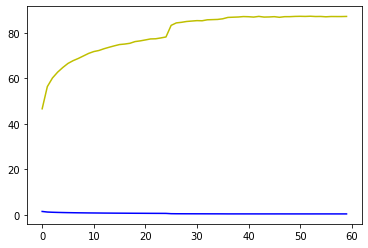

In [5]:
plt.plot(losses, 'b')
plt.plot(accs, 'y')